In [14]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install numpyro
!pip install pandas
!pip install --upgrade xlrd==2.0.1
!pip install umap-learn

# Import required libraries
import pandas as pd
import os
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import numpy as np
import math
import arviz as az
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import random as rd
import seaborn as sns
import jax.numpy as jnp
from numpyro.distributions.transforms import AffineTransform
from scipy.stats import ttest_ind
import plotly.express as px
from sklearn.decomposition import
from sklearn.manifold import TSNE
import umap.umap_ as umap


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


In [12]:
import jax.numpy as jnp
from numpyro.distributions.transforms import AffineTransform

# Define a custom distribution class that represents either a zero or a normal distribution
class ZeroOrNormal(dist.Distribution):
    support = dist.constraints.real

    def __init__(self, mu, sigma, v):
        self.mu = mu
        self.sigma = sigma
        self.v = v
        super().__init__(batch_shape=(), event_shape=(1,))

    def sample(self, key, sample_shape=()):
        if self.v == 1:
            return numpyro.sample("normal", dist.Normal(jnp.full(sample_shape, self.mu), jnp.full(sample_shape, self.sigma)))
        else:
            return jnp.zeros(sample_shape)

    def log_prob(self, value):
        normal_lp = dist.Normal(jnp.full(value.shape, self.mu), jnp.full(value.shape, self.sigma)).log_prob(value)
        zero_lp = jnp.log(self.v == 0)
        return jnp.where(value == 0, zero_lp, normal_lp)

# Define the logistic function
def logistic(X, alpha, beta):
    tmp = -alpha * (X - beta)
    return 1 / (1 + math.e**(tmp))

In [15]:
# Use a dictionary to store dynamically created variables
df = locals()

# Loop through 38 sheets in the Excel file to read data and run the model
for i in range(1,39):

    # Read data from the Excel file
    df['df_dp'+str(i)] = pd.read_excel('/content/drive/MyDrive/hikikomoridata/DP.xls',sheet_name='Sheet'+str(i))
    df['z_a_dp'+str(i)] = df['df_dp'+str(i)]['attractive'].values
    df['z_t_dp'+str(i)] = df['df_dp'+str(i)]['trust'].values
    df['m_dp'+str(i)] = df['df_dp'+str(i)]['money'].values
    df['p_dp'+str(i)] = df['df_dp'+str(i)]['pay'].values

    # Define the trust game model
    def trustgame(z_a, z_t, m=None, p=None):
        w_a = numpyro.sample('w_a', dist.Normal(0, 1))
        w_t = numpyro.sample('w_t', dist.Normal(0, 1))
        w_0 = numpyro.sample('w_0', dist.Normal(0, 1))
        alpha_r = numpyro.sample('alpha_r', dist.Gamma(5))
        beta_r = numpyro.sample('beta_r', dist.Normal(1, 1))
        sigma_r = numpyro.sample('sigma_r', dist.HalfNormal(0.5))
        a = numpyro.sample('a', dist.Normal(100, 100))
        b = numpyro.sample('b', dist.Normal(100, 100))
        sigma_m = numpyro.sample('sigma_m', dist.HalfNormal(100))
        r = numpyro.sample('r', dist.Normal(w_a * z_a + w_t * z_t+w_0, sigma_r))
        x = logistic(r, alpha_r, beta_r)

        p = numpyro.sample('p', dist.Bernoulli(x), obs=p)
        m_dist = ZeroOrNormal((a * r + b), sigma_m, p)
        m = numpyro.sample("m", m_dist, obs=m)

    # Run the model using NUTS sampler
    nuts_kernel = NUTS(trustgame)
    df['mcmc_dp'+str(i)] = MCMC(nuts_kernel, num_warmup=1000, num_samples=3000)
    rng_key = random.PRNGKey(3407)
    df['mcmc_dp'+str(i)].run(rng_key, df['z_a_dp'+str(i)], df['z_t_dp'+str(i)], m=df['m_dp'+str(i)],p=df['p_dp'+str(i)])
    i = i+1


ImportError: ignored

In [ ]:
# Lists to store the posterior means of the parameters for all 38 runs
w_a_dpsum = []
w_a_dpsum=[]
w_t_dpsum=[]
w_0_dpsum=[]
alpha_dpsum=[]
beta_dpsum = []
a_dpsum=[]
b_dpsum=[]
sigma_r_dpsum=[]
sigma_m_dpsum=[]

# Extract the posterior means of the parameters for all 38 runs
for i in range(1,39):
    posterior_samples = df['mcmc_dp'+str(i)].get_samples()
    w_a_dpsum.append(np.mean(posterior_samples["w_a"]))
    w_t_dpsum.append(np.mean(posterior_samples["w_t"]))
    w_0_dpsum.append(np.mean(posterior_samples["w_0"]))
    alpha_dpsum.append(np.mean(posterior_samples["alpha_r"]))
    beta_dpsum.append(np.mean(posterior_samples["beta_r"]))
    a_dpsum.append(np.mean(posterior_samples["a"]))
    b_dpsum.append(np.mean(posterior_samples["b"]))
    sigma_r_dpsum.append(np.mean(posterior_samples["sigma_r"]))
    sigma_m_dpsum.append(np.mean(posterior_samples["sigma_m"]))
    i = i+1

# Save the results to CSV files
np.savetxt("/content/drive/MyDrive/hikikomoridata/alpha_dpsum.csv", alpha_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/beta_dpsum.csv", beta_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/w_t_dpsum.csv", w_t_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/w_a_dpsum.csv", w_a_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/w_0_dpsum.csv", w_0_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/a_dpsum.csv", a_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/b_dpsum.csv", b_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/sigma_r_dpsum.csv", sigma_r_dpsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/sigma_m_dpsum.csv", sigma_m_dpsum)


In [ ]:
# Use a dictionary to store dynamically created variables
df = locals()

# Loop through 38 sheets in the Excel file to read data and run the model
for i in range(1,39):
    # Read data from the Excel file
    df['df_hc'+str(i)] = pd.read_excel('/content/drive/MyDrive/hikikomoridata/HC.xls',sheet_name='Sheet'+str(i))
    df['z_a_hc'+str(i)] = df['df_hc'+str(i)]['attractive'].values
    df['z_t_hc'+str(i)] = df['df_hc'+str(i)]['trust'].values
    df['m_hc'+str(i)] = df['df_hc'+str(i)]['money'].values
    df['p_hc'+str(i)] = df['df_hc'+str(i)]['pay'].values

    # Define the trust game model
    def trustgame(z_a, z_t, m=None, p=None):
        w_a = numpyro.sample('w_a', dist.Normal(0, 1))
        w_t = numpyro.sample('w_t', dist.Normal(0, 1))
        w_0 = numpyro.sample('w_0', dist.Normal(0, 1))
        alpha_r = numpyro.sample('alpha_r', dist.Gamma(5))
        beta_r = numpyro.sample('beta_r', dist.Normal(1, 1))
        sigma_r = numpyro.sample('sigma_r', dist.HalfNormal(0.5))
        a = numpyro.sample('a', dist.Normal(100, 100))
        b = numpyro.sample('b', dist.Normal(100, 100))
        sigma_m = numpyro.sample('sigma_m', dist.HalfNormal(100))
        r = numpyro.sample('r', dist.Normal(w_a * z_a + w_t * z_t+w_0, sigma_r))
        x = logistic(r, alpha_r, beta_r)

        p = numpyro.sample('p', dist.Bernoulli(x), obs=p)
        m_dist = ZeroOrNormal((a * r + b), sigma_m, p)
        m = numpyro.sample("m", m_dist, obs=m)

    # Run the model using NUTS sampler
    nuts_kernel = NUTS(trustgame)
    df['mcmc_hc'+str(i)] = MCMC(nuts_kernel, num_warmup=1000, num_samples=3000)
    rng_key = random.PRNGKey(0)
    df['mcmc_hc'+str(i)].run(rng_key, df['z_a_hc'+str(i)], df['z_t_hc'+str(i)], m=df['m_hc'+str(i)],p=df['p_hc'+str(i)])
    i = i+1


In [ ]:
# Lists to store the posterior means of the parameters for all 38 runs
w_a_hcsum=[]
w_t_hcsum=[]
w_0_hcsum=[]
alpha_hcsum=[]
beta_hcsum = []
a_hcsum=[]
b_hcsum=[]
sigma_r_hcsum=[]
sigma_m_hcsum=[]

# Extract the posterior means of the parameters for all 38 runs
for i in range(1,39):
    posterior_samples = df['mcmc_hc'+str(i)].get_samples()
    w_a_hcsum.append(np.mean(posterior_samples["w_a"]))
    w_t_hcsum.append(np.mean(posterior_samples["w_t"]))
    w_0_hcsum.append(np.mean(posterior_samples["w_0"]))
    alpha_hcsum.append(np.mean(posterior_samples["alpha_r"]))
    beta_hcsum.append(np.mean(posterior_samples["beta_r"]))
    a_hcsum.append(np.mean(posterior_samples["a"]))
    b_hcsum.append(np.mean(posterior_samples["b"]))
    sigma_r_hcsum.append(np.mean(posterior_samples["sigma_r"]))
    sigma_m_hcsum.append(np.mean(posterior_samples["sigma_m"]))
    i = i+1

# Save the results to CSV files
np.savetxt("/content/drive/MyDrive/hikikomoridata/alpha_hcsum.csv", alpha_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/beta_hcsum.csv", beta_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/w_t_hcsum.csv", w_t_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/w_a_hcsum.csv", w_a_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/w_0_hcsum.csv", w_0_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/a_hcsum.csv", a_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/b_hcsum.csv", b_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/sigma_r_hcsum.csv", sigma_r_hcsum)
np.savetxt("/content/drive/MyDrive/hikikomoridata/sigma_m_hcsum.csv", sigma_m_hcsum)

In [16]:
# Load the data from the Excel file
entropy_post = pd.read_excel('/content/drive/MyDrive/hikikomoridata/hcdp_post_232227.xlsx')

# Filter out rows where 'm_entropy' is less than 1.5
post = entropy_post.drop(entropy_post[entropy_post['m_entropy'] < 1.5].index)

# Further filter to keep only rows where 'YYS_trust_sum' is not NaN
postall = post[post['YYS_trust_sum'].notna()]

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning:

8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning:

15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning:

8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning:

15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning:

12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.10/dist-packages/seaborn/categoric

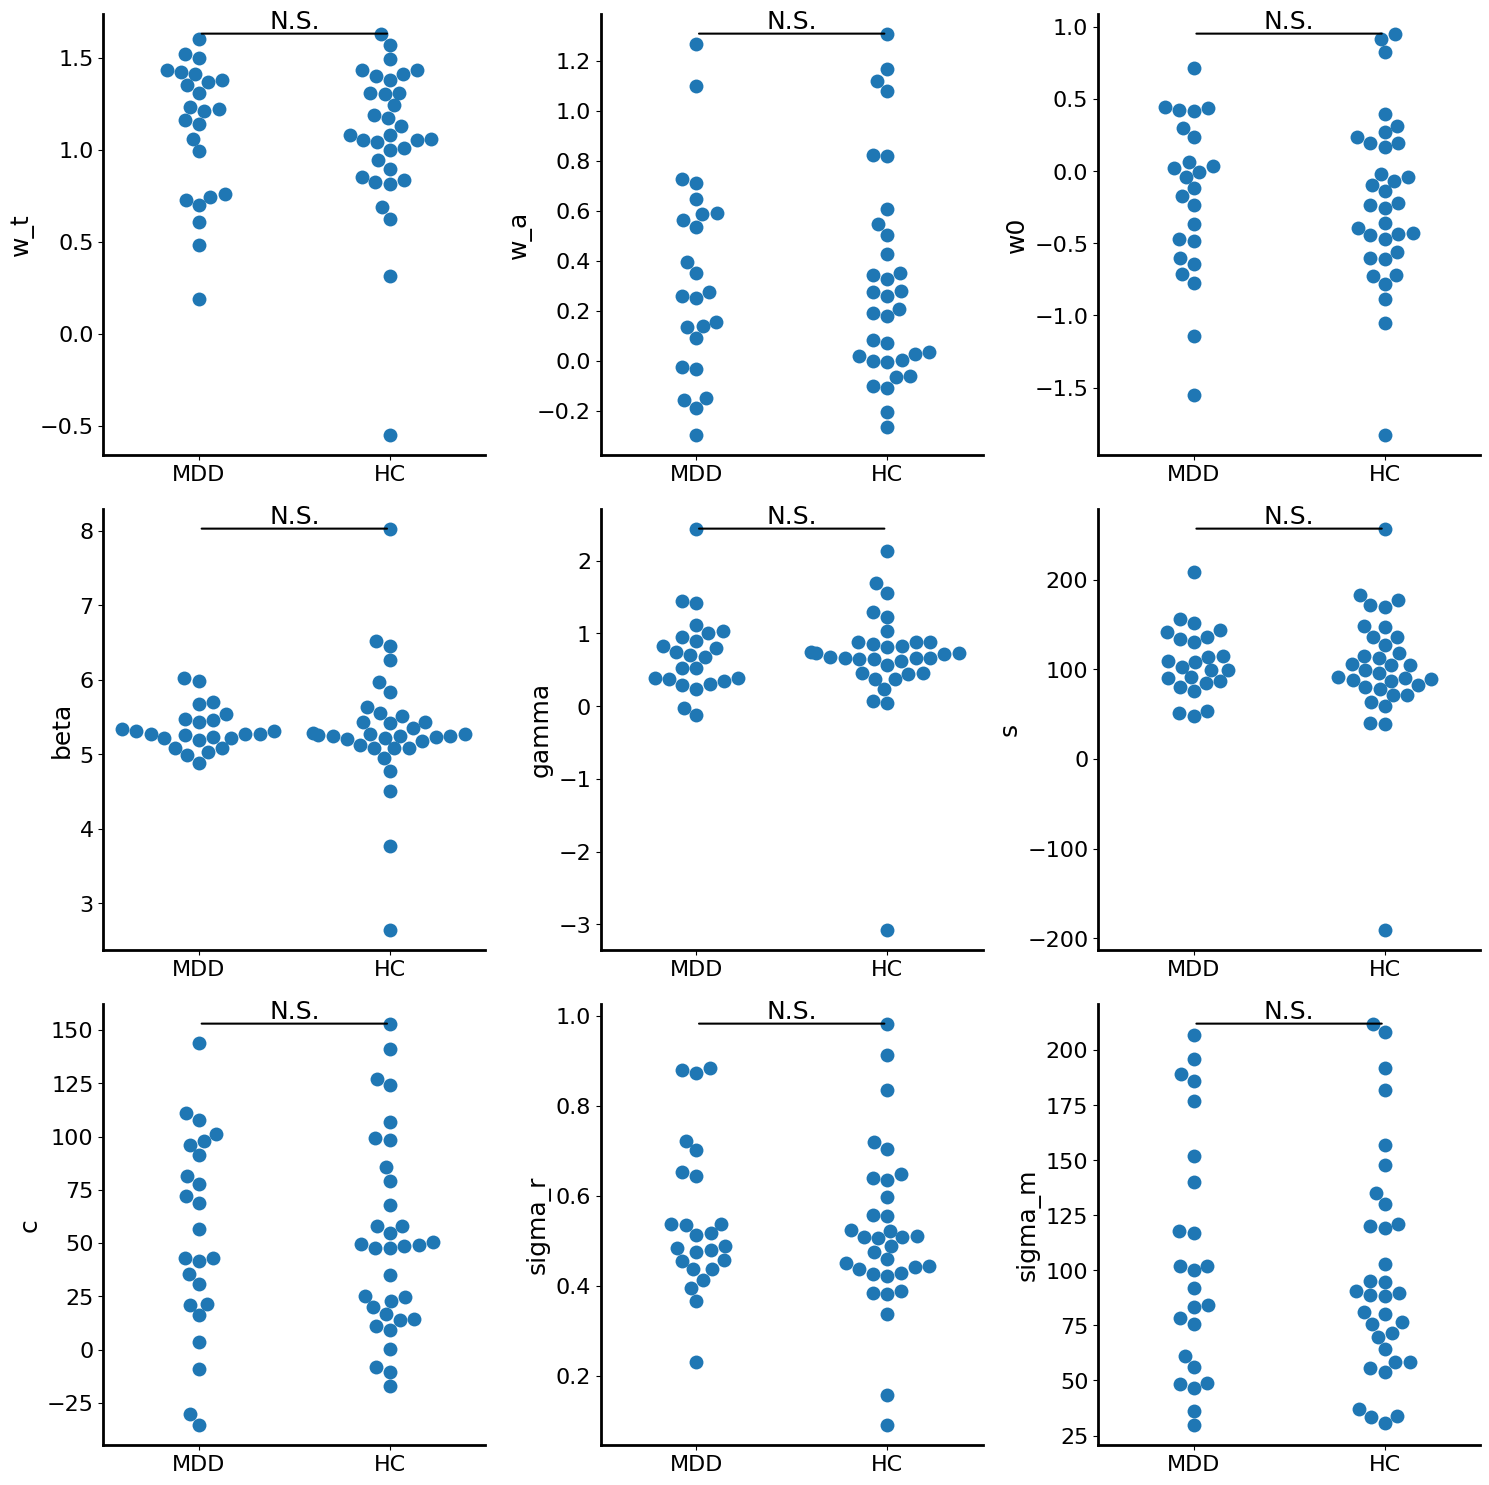

In [17]:
# List of variables to be plotted
variables = ["w_t", "w_a", "w0", "beta", "gamma", "s", "c", "sigma_r", "sigma_m"]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Flatten the 3x3 grid of axes for easy iteration
ax_flat = axes.ravel()

# Loop through each variable and create a swarmplot
for i, var in enumerate(variables):
    ax = ax_flat[i]
    sns.swarmplot(x="group", y=var, dodge=True, data=post, ax=ax, size=10)

    # Adjust the font size of the axis labels
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel(var, fontsize=18)
    ax.set_xlabel('')

    # Hide the top and right borders of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Extract data for the two groups
    group1 = post[post['group'] == 'MDD'][var]
    group2 = post[post['group'] == 'HC'][var]

    # Perform a t-test between the two groups
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    # Display significance level (either N.S. or *) based on the p-value
    y_max = post[var].max()
    ax.text(0.5, y_max, 'N.S.' if p_val > 0.05 else '*', ha='center', va='bottom', fontsize=18)
    ax.annotate("", xy=(0, y_max), xycoords='data',
                xytext=(1, y_max), textcoords='data',
                arrowprops=dict(arrowstyle="-", lw=1.5))

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()


In [ ]:
# Extract features for PCA
X = postall[["w_t", "w_a", "w0", "beta", "gamma", "s", "c", "sigma_r", "sigma_m"]]

# Perform PCA and reduce the data to 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(X)

# Visualize the PCA results
fig = px.scatter(components, x=0, y=1,
                 color=postall.group, labels={'color': 'Group'},
                 width=800, height=800,
                 title="PCA")
fig.update_layout(font_size=20, hoverlabel_font_size=20)
fig.update_traces(marker_size=10)
fig.update_layout(legend=dict(x=0.9,
                              y=1.2,
                              xanchor='left',
                              yanchor='top'
                              ))
fig.show()

In [ ]:
# Extract features for t-SNE
features = ["w_t", "w_a", "w0", "beta", "gamma", "s", "c", "sigma_r", "sigma_m"]
tsnefeatures = postall.loc[:, features]

# Perform t-SNE and reduce the data to 2 components
tsne = TSNE(n_components=2, random_state=1)
projections = tsne.fit_transform(tsnefeatures)

# Visualize the t-SNE results
fig = px.scatter(
    projections, x=0, y= 1,
    color=postall.group, labels={'color': 'Group'},
    width=800, height=800,title="t_SNE"
)
fig.update_layout(font_size=20, hoverlabel_font_size=20)
fig.update_traces(marker_size=10)
fig.update_layout(legend=dict(x=0.9,
                              y=1.2,
                              xanchor='left',
                              yanchor='top'
                              ))
fig.show()

In [ ]:
# Extract features for UMAP
umapfeatures = postall.loc[:, features]

# Perform UMAP and reduce the data to 2 components
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(umapfeatures)

# Visualize the UMAP results
fig = px.scatter(
    proj_2d , x=0, y= 1,
    color=postall.group, labels={'color': 'Group'},
    width=800, height=800,title="UMAP"
)
fig.update_layout(font_size=20, hoverlabel_font_size=20)
fig.update_traces(marker_size=10)
fig.update_layout(legend=dict(x=0.9,
                              y=1.2,
                              xanchor='left',
                              yanchor='top'
                              ))
fig.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

